
# Data preprocessing

In [1]:
% cd..

/Users/fulco/Desktop/recommender-systems-challenge


In [2]:
import numpy as np
import scipy.sparse as sps
from sklearn import feature_extraction

from Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from reader import load_urm, load_icm, load_target
from evaluate import _get_instance

In [3]:
res_dir = 'result_experiments/csv'
output_root_path = "../result_experiments/"


In [8]:
URM_all = load_urm()

ICM_channel = load_icm("data_ICM_channel.csv", weight=1)
ICM_event = load_icm("data_ICM_event.csv", weight=1)
ICM_genre = load_icm("data_ICM_genre.csv", weight=1)
ICM_subgenre = load_icm("data_ICM_subgenre.csv", weight=1)

ICM_all = sps.hstack([ICM_genre, ICM_subgenre, ICM_channel, ICM_event]).tocsr()
ICMs = [ICM_genre, ICM_subgenre, ICM_channel, ICM_event, ICM_all]

In [10]:
URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage=0.80)

evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

EvaluatorHoldout: Ignoring 6 ( 0.0%) Users that have less than 1 test interactions


In [11]:
n_users = 13650
n_item = 18059

In [23]:
profile_length = np.ediff1d(sps.csr_matrix(URM_train).indptr)
print("profile", profile_length, profile_length.shape)

block_size = int(len(profile_length) * 0.01)
print("block_size", block_size)

sorted_users = np.argsort(profile_length)
print("sorted users", sorted_users)

profile [132 467 121 ... 209 149 262] (13650,)
block_size 136
sorted users [ 1648  3368 11326 ...  1141  8526   317]


array([3853, 5269, 2721, 1162,  414,  147,   47,   31,    4,    2])

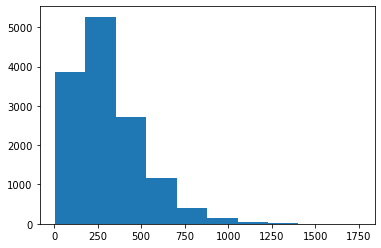

In [24]:
import matplotlib.pyplot as plt

counts, bins = np.histogram(profile_length)
plt.hist(bins[:-1], bins, weights=counts)

In [22]:
for group_id in range(0, 10):
    start_pos = group_id * block_size
    end_pos = min((group_id + 1) * block_size, len(profile_length))

    users_in_group = sorted_users[start_pos:end_pos]

    users_in_group_p_len = profile_length[users_in_group]

    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id,
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))

Group 0, #users in group 136, average p.len 12.74, median 13.0, min 4, max 17
Group 1, #users in group 136, average p.len 23.14, median 23.0, min 17, max 28
Group 2, #users in group 136, average p.len 32.69, median 32.0, min 28, max 37
Group 3, #users in group 136, average p.len 42.90, median 43.0, min 37, max 48
Group 4, #users in group 136, average p.len 50.77, median 51.0, min 48, max 54
Group 5, #users in group 136, average p.len 57.85, median 58.0, min 54, max 62
Group 6, #users in group 136, average p.len 66.18, median 66.0, min 62, max 70
Group 7, #users in group 136, average p.len 73.58, median 74.0, min 70, max 77
Group 8, #users in group 136, average p.len 80.72, median 81.0, min 77, max 84
Group 9, #users in group 136, average p.len 87.10, median 87.0, min 84, max 90


In [25]:
from Recommenders.KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender
from Recommenders.NonPersonalizedRecommender import TopPop
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.SLIM.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender
from Recommenders.SLIM.SLIMElasticNetRecommender import SLIMElasticNetRecommender

MAP_recommender_per_group = {}

collaborative_recommender_class = {"TopPop": TopPop,
                                   "UserKNNCF": UserKNNCFRecommender,
                                   "ItemKNNCF": ItemKNNCFRecommender,
                                   "P3alpha": P3alphaRecommender,
                                   "RP3beta": RP3betaRecommender,
                                   "SLIMElasticNetRecommender": SLIMElasticNetRecommender,
                                   "PureSVDRecommender": PureSVDRecommender,
                                   }

content_recommender_class = {"ItemKNNCBF": ItemKNNCBFRecommender,
                             }
recommender_object_dict = {}

# for label, recommender_class in collaborative_recommender_class.items():
#
#     recommender_object = recommender_class(URM_train)
#
#     if isinstance(recommender_object, ItemKNNCFRecommender):
#         fit_params = {'topK': 189, 'shrink': 0, 'similarity': 'cosine', 'normalize': True,
#                       'feature_weighting': 'TF-IDF'}
#     elif isinstance(recommender_object, IALSRecommender):
#         fit_params = {'num_factors': 55, 'epochs': 50, 'confidence_scaling': 'log',
#                       'alpha': 0.06164752624981533, 'epsilon': 0.21164021855039056, 'reg': 0.002507116338282967}
#     elif isinstance(recommender_object, RP3betaRecommender):
#         fit_params = {'topK': 40, 'alpha': 0.4208737801266599, 'beta': 0.5251543657397256,
#                       'normalize_similarity': True}
#     elif isinstance(recommender_object, PureSVDRecommender):
#         fit_params = {'num_factors': 29}
#     else:
#         fit_params = {}
#
#     if isinstance(recommender_object, SLIMElasticNetRecommender):
#         recommender_object.load_model(output_root_path, file_name="slimelastic_urmall.zip")
#     else:
#         recommender_object.fit(**fit_params)
#
#     recommender_object_dict[label] = recommender_object

for label, recommender_class in content_recommender_class.items():
    recommender_object = recommender_class(URM_train, ICM_channel)
    if isinstance(recommender_object, ItemKNNCBFRecommender):
        fit_params = {'topK': 1000, 'shrink': 1000, 'similarity': 'cosine', 'normalize': False,
                      'feature_weighting': 'TF-IDF'}

    recommender_object.fit()
    recommender_object_dict[label] = recommender_object


ItemKNNCBFRecommender: ICM Detected 352 ( 1.9%) items with no features.
Similarity column 18059 (100.0%), 10658.32 column/sec. Elapsed time 1.69 sec


In [ ]:
% ls

In [28]:
cutoff = 10

for group_id in range(0, 10):

    start_pos = group_id * block_size
    end_pos = min((group_id + 1) * block_size, len(profile_length))

    users_in_group = sorted_users[start_pos:end_pos]

    users_in_group_p_len = profile_length[users_in_group]

    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id,
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))

    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
    users_not_in_group = sorted_users[users_not_in_group_flag]

    evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[cutoff], ignore_users=users_not_in_group)

    for label, recommender in recommender_object_dict.items():
        result_df, _ = evaluator_test.evaluateRecommender(recommender)
        if label in MAP_recommender_per_group:
            MAP_recommender_per_group[label].append(result_df.loc[cutoff]["MAP"])
        else:
            MAP_recommender_per_group[label] = [result_df.loc[cutoff]["MAP"]]
        print(result_df.loc[cutoff]["MAP"])

Group 0, #users in group 136, average p.len 12.74, median 13.0, min 4, max 17
EvaluatorHoldout: Ignoring 6 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13514 Users
EvaluatorHoldout: Processed 131 (100.0%) in 0.64 sec. Users per second: 206
0.000400763358778626
Group 1, #users in group 136, average p.len 23.14, median 23.0, min 17, max 28
EvaluatorHoldout: Ignoring 6 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13514 Users
EvaluatorHoldout: Processed 135 (100.0%) in 0.62 sec. Users per second: 219
0.0023106995884773665
Group 2, #users in group 136, average p.len 32.69, median 32.0, min 28, max 37
EvaluatorHoldout: Ignoring 6 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13514 Users
EvaluatorHoldout: Processed 136 (100.0%) in 0.62 sec. Users per second: 220
0.005615371148459385
Group 3, #users in group 136, average p.len 42.90, median 43.0, min 37, max 48
EvaluatorHoldout: Ignoring 

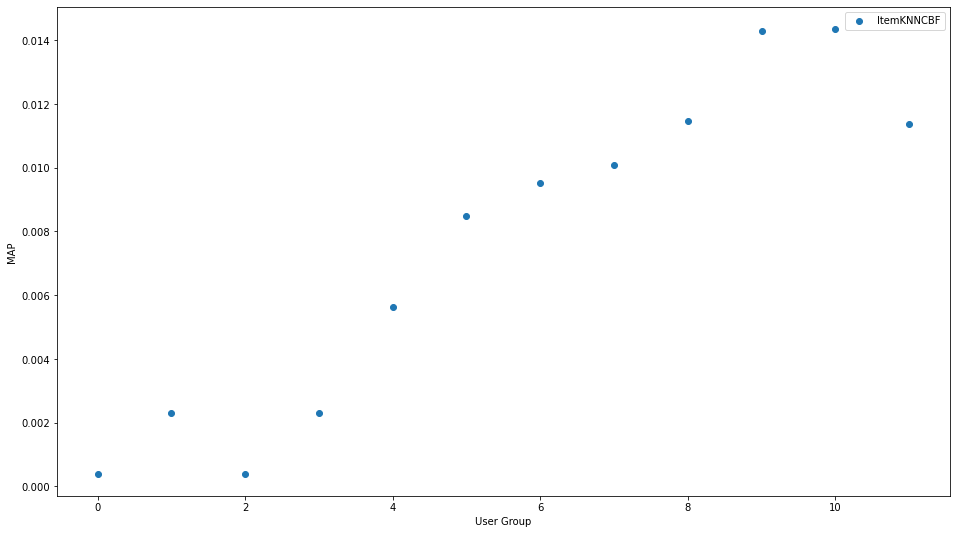

In [29]:
import matplotlib.pyplot as plt

_ = plt.figure(figsize=(16, 9))
for label, recommender in recommender_object_dict.items():
    results = MAP_recommender_per_group[label]
    plt.scatter(x=np.arange(0, len(results)), y=results, label=label)
plt.ylabel('MAP')
plt.xlabel('User Group')
plt.legend()
plt.show()